# Stocker Predictor using NeuralProphet

In [1]:
!pip install -r ../requirements.txt  --quiet

## prerequisites

In [8]:
%%writefile model.py
import joblib
import datetime
import pandas as pd

import yfinance as yf

from neuralprophet import NeuralProphet

import argparse
from pathlib import Path 

In [9]:
%%writefile -a model.py
TRADING_DAYS_IN_ONE_YEAR = 252
TODAY = datetime.date.today()
START = datetime.date.today() - datetime.timedelta(days=365*3)

## 1. Get data

In [4]:
# get_data
ticker = 'MSFT'
data = yf.download(ticker, START, TODAY)
data.reset_index(inplace=True)
data.rename(columns={"Date": "ds", "Adj Close": "y"}, inplace=True)
data = data[["ds", "y"]]

[*********************100%%**********************]  1 of 1 completed


In [6]:
# %%writefile -a model.py
def get_data(ticker:str='MSFT'):
    data = yf.download(ticker, START, TODAY)
    data.reset_index(inplace=True)
    data.rename(columns={"Date": "ds", "Adj Close": "y"}, inplace=True)
    data = data[["ds", "y"]]
    return data

In [7]:
data = get_data()
assert data.shape == ( 753, 2 )

NameError: name 'yf' is not defined

## 2. Training

In [6]:
model = NeuralProphet( quantiles=[0.05, 0.95])
metrics = model.fit(data, freq="D")

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.149% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 213
WARNING - (py.warnings._showwarnmsg) - /Users/flora/miniforge3/envs/stock-arima/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

WARNING - (NP.config.s

Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [7]:
metrics.tail()

,MAE,RMSE,Loss,RegLoss,epoch
208,7.481311,8.991103,0.002105,0.0,208
209,7.155872,8.650392,0.001984,0.0,209
210,7.264560,8.734790,0.002005,0.0,210
211,7.523394,8.977634,0.002137,0.0,211
212,7.282983,8.791928,0.001997,0.0,212


## 4. Get Future Dates

In [8]:
days = 14
future_date = pd.bdate_range(start=TODAY, periods=days)[-1]
dates = pd.bdate_range(start=TODAY, end=future_date.strftime("%Y-%m-%d"))
future = pd.DataFrame({"ds": dates, "y": 0})
future = pd.concat([data, future]).reset_index(drop=True)

## 5. Make Predictions

In [9]:
forecast = model.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.219% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.219% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 48it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [10]:
forecast.tail(days)

,ds,y,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_yearly,season_weekly
753,2023-09-11,0.0,330.514954,318.114014,336.515808,356.454224,-8.171044,-17.768227
754,2023-09-12,0.0,330.668091,317.965942,337.376831,356.805664,-8.662396,-17.475170
755,2023-09-13,0.0,330.670288,318.306885,336.389038,357.157043,-9.129340,-17.357405
756,2023-09-14,0.0,330.916138,318.014069,335.624023,357.508453,-9.571397,-17.020924
757,2023-09-15,0.0,330.803833,317.545593,335.491455,357.859894,-9.988242,-17.067841
758,2023-09-18,0.0,330.059509,317.072449,335.897552,358.914185,-11.086450,-17.768227
759,2023-09-19,0.0,330.388367,316.997742,337.097992,359.265594,-11.402047,-17.475170
760,2023-09-20,0.0,330.566772,317.414886,336.446106,359.617035,-11.692842,-17.357405
761,2023-09-21,0.0,330.988281,317.200897,336.011047,359.968445,-11.959242,-17.020924
762,2023-09-22,0.0,331.050293,316.813965,336.200439,360.319885,-12.201726,-17.067841


## 6. Plotting

In [11]:
model.plot(forecast)

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': 'rgba(45, 146, 255, 1.0)', 'width': 2},
              'mode': 'lines',
              'name': 'yhat1',
              'type': 'scatter',
              'uid': '137ec3dc-1ca7-4644-b611-728833cb031c',
              'x': array([datetime.datetime(2020, 9, 11, 0, 0),
                          datetime.datetime(2020, 9, 14, 0, 0),
                          datetime.datetime(2020, 9, 15, 0, 0), ...,
                          datetime.datetime(2023, 9, 26, 0, 0),
                          datetime.datetime(2023, 9, 27, 0, 0),
                          datetime.datetime(2023, 9, 28, 0, 0)], dtype=object),
              'y': array([204.08699036, 202.07281494, 201.97831726, ..., 331.30657959,
                          331.644104  , 332.22070312])},
             {'fillcolor': 'rgba(45, 146, 255, 0.2)',
              'line': {'color': 'rgba(45, 146, 255, 0.2)', 'width': 1},
              'mode': 'lines',
            

In [12]:
model.plot_components(forecast)

FigureWidgetResampler({
    'data': [{'line': {'color': '#2d92ff', 'width': 2},
              'mode': 'lines',
              'name': 'Trend',
              'showlegend': False,
              'type': 'scatter',
              'uid': 'daf742b4-7666-4c5b-8607-054e58e516b0',
              'x': array([datetime.datetime(2020, 9, 11, 0, 0),
                          datetime.datetime(2020, 9, 14, 0, 0),
                          datetime.datetime(2020, 9, 15, 0, 0), ...,
                          datetime.datetime(2023, 9, 26, 0, 0),
                          datetime.datetime(2023, 9, 27, 0, 0),
                          datetime.datetime(2023, 9, 28, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([229.69665527, 229.72744751, 229.73770142, ..., 361.72558594,
                          362.07702637, 362.4284668 ]),
              'yaxis': 'y'},
             {'line': {'color': '#2d92ff', 'width': 2},
              'mode': 'lines',
              'name': 'yearly seasona

In [13]:
model.plot_parameters()

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': '#2d92ff', 'width': 2},
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> Trend <i style="color:#fc9944">~1D</i>',
              'type': 'scatter',
              'uid': 'ee8ed5ee-c058-437c-9949-4a516c7e37df',
              'x': array([datetime.datetime(2020, 9, 11, 0, 0),
                          datetime.datetime(2020, 9, 12, 0, 0),
                          datetime.datetime(2020, 9, 13, 0, 0), ...,
                          datetime.datetime(2023, 9, 5, 0, 0),
                          datetime.datetime(2023, 9, 6, 0, 0),
                          datetime.datetime(2023, 9, 8, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([229.69665444, 229.70691678, 229.71717911, ..., 354.34564205,
                          354.69706778, 355.39991924]),
              'yaxis': 'y'},
             {'marker': {'color': '#2d92ff'},
              'na

In [14]:
!pip install torchsummary torchviz --quiet

In [15]:
from torchviz import make_dot

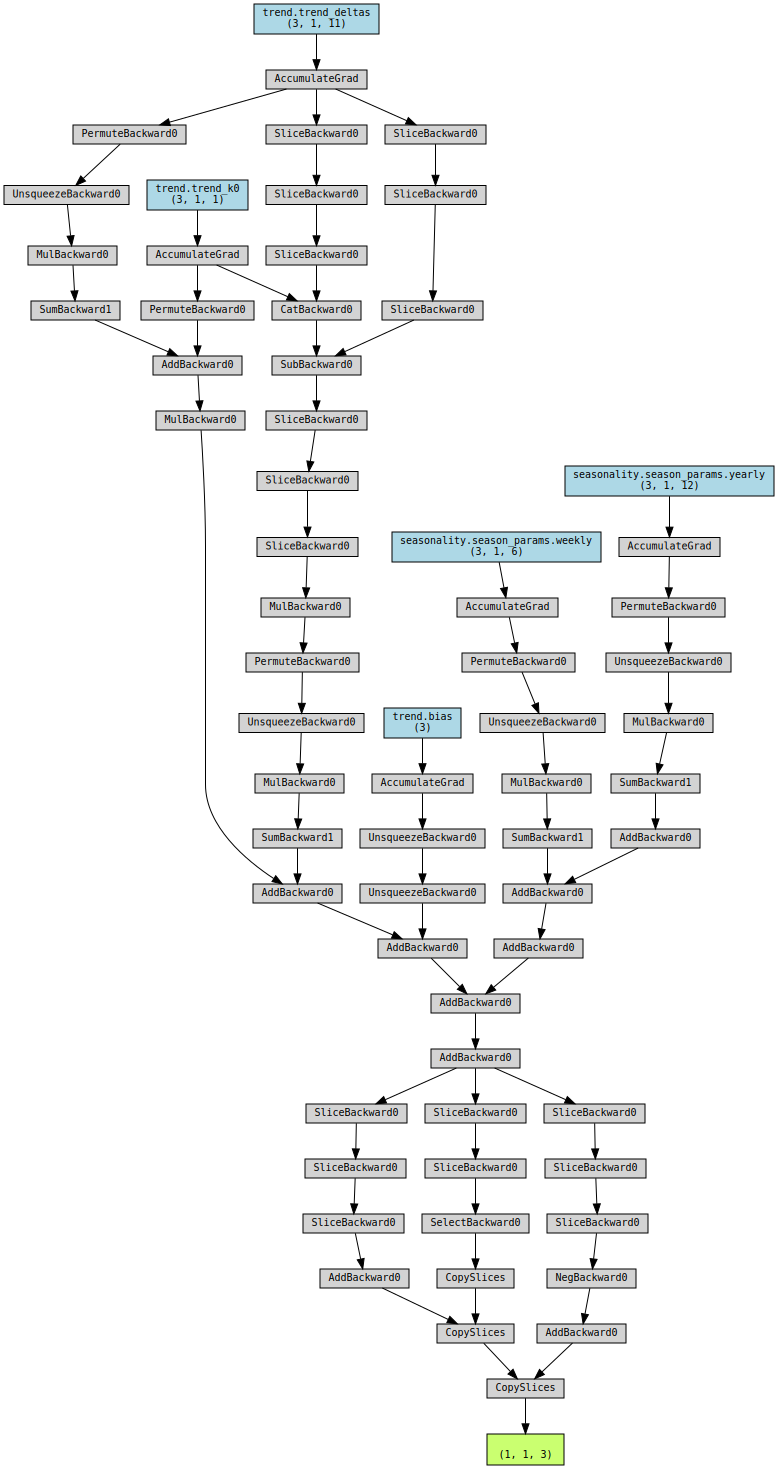

In [16]:
fig = make_dot(model.model.train_epoch_prediction, params=dict(model.model.named_parameters()))
# fig_glob.render(filename='img/fig_glob')
display(fig)